In [1]:
%load_ext autoreload
%autoreload
import os
import sys
import numpy as np
#Select which GPU to use if necessary
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1
import mongo
import time
import pickle


env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [2]:
with open('./input/feature_dimensions.pkl', 'rb') as file_handle:
    orig_atom_fea_len, nbr_fea_len = pickle.load(file_handle)

with open('./input/splits_gasdb.pkl', 'rb') as file_handle:
    splits = pickle.load(file_handle)

docs_train = splits['docs_train']
docs_val = splits['docs_val']
sdts_train, sdts_val = splits['sdts_train'], splits['sdts_val']
targets_train, targets_val = splits['targets_train'], splits['targets_val']

In [3]:
from torch.optim import Adam, SGD
from sklearn.model_selection import ShuffleSplit
from skorch.callbacks import Checkpoint, LoadInitState #needs skorch 0.4.0, conda-forge version at 0.3.0 doesn't cut it

from cgcnn.data import collate_pool, MergeDataset
from cgcnn.model_pyro import CrystalGraphConvNet
from skorch import NeuralNetRegressor
import torch
import skorch.callbacks.base


cuda = torch.cuda.is_available()
if cuda:
    device = torch.device("cuda")
else:
    device='cpu'
print('device', device)

device cuda


In [5]:
from skorch.dataset import CVSplit
from skorch.callbacks.lr_scheduler import WarmRestartLR, LRScheduler
from adamwr.adamw import AdamW
from adamwr.cosine_scheduler import CosineLRWithRestarts
from sklearn.model_selection import train_test_split
from skorch import callbacks
# train_test_splitter = ShuffleSplit(test_size=0.25, random_state=42)

#Make a checkpoint to save parameters every time there is a new best for validation lost
cp = Checkpoint(monitor='valid_loss_best',fn_prefix='valid_best_')

#Callback to load the checkpoint with the best validation loss at the end of training

class train_end_load_best_valid_loss(skorch.callbacks.base.Callback):
    def on_train_end(self, net, X, y):
        net.load_params('valid_best_params.pt')
        
load_best_valid_loss = train_end_load_best_valid_loss()

LR_schedule = callbacks.lr_scheduler.LRScheduler('MultiStepLR', milestones=[100], gamma=0.1)

#############
# To extract intermediate features, set the forward takes only the first return value to calculate loss
class MyNet(NeuralNetRegressor):
    def get_loss(self, y_pred, y_true, **kwargs):
        y_pred = y_pred[0] if isinstance(y_pred, tuple) else y_pred  # discard the 2nd output
        return super().get_loss(y_pred, y_true, **kwargs)
## return features = net.forward(SDT_test)
############

net = MyNet(
    CrystalGraphConvNet,
    module__orig_atom_fea_len = orig_atom_fea_len,
    module__nbr_fea_len = nbr_fea_len,
    batch_size=214,
    module__classification=False,
    lr=0.0056,
    max_epochs= 30, 
    module__atom_fea_len=46,
    module__h_fea_len=83,
    module__n_conv=8, #8
    module__n_h=4,
    optimizer__weight_decay=1e-5,
    optimizer=AdamW,
    iterator_train__pin_memory=True,
    iterator_train__num_workers=0,
    iterator_train__collate_fn = collate_pool,
    iterator_valid__pin_memory=True,
    iterator_valid__num_workers=0,
    iterator_valid__collate_fn = collate_pool,
    device=device,
#     criterion=torch.nn.MSELoss,
    criterion=torch.nn.L1Loss,
    dataset=MergeDataset,
#     train_split = CVSplit(cv=train_test_splitter),
    callbacks=[cp, load_best_valid_loss, LR_schedule]
)

In [6]:
net.initialize()
# net.fit(SDT_training, target_training)

<class '__main__.MyNet'>[initialized](
  module_=CrystalGraphConvNet(
    (fcs_embedding): Linear(in_features=98, out_features=46, bias=True)
    (convs): ModuleList(
      (0): ConvLayer(
        (fc_full): Linear(in_features=98, out_features=92, bias=True)
        (sigmoid): Sigmoid()
        (softplus1): Softplus(beta=1, threshold=20)
        (bn1): BatchNorm1d(92, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(46, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (softplus2): Softplus(beta=1, threshold=20)
      )
      (1): ConvLayer(
        (fc_full): Linear(in_features=98, out_features=92, bias=True)
        (sigmoid): Sigmoid()
        (softplus1): Softplus(beta=1, threshold=20)
        (bn1): BatchNorm1d(92, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(46, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (softplus2): Softplus(beta=1, threshold

In [7]:
# net.initialize()
# net.load_params(f_history='valid_best_history.json',
#                 f_optimizer= 'valid_best_optimizer.pt', 
#                 f_params='valid_best_params.pt')

In [8]:
import pyro
from pyro.distributions import Normal, Categorical, Uniform
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam, AdamW
pyro.enable_validation(True)

In [9]:
for n, p in net.module_.named_parameters():
    print(n, p.shape)

fcs_embedding.weight torch.Size([46, 98])
fcs_embedding.bias torch.Size([46])
convs.0.fc_full.weight torch.Size([92, 98])
convs.0.fc_full.bias torch.Size([92])
convs.0.bn1.weight torch.Size([92])
convs.0.bn1.bias torch.Size([92])
convs.0.bn2.weight torch.Size([46])
convs.0.bn2.bias torch.Size([46])
convs.1.fc_full.weight torch.Size([92, 98])
convs.1.fc_full.bias torch.Size([92])
convs.1.bn1.weight torch.Size([92])
convs.1.bn1.bias torch.Size([92])
convs.1.bn2.weight torch.Size([46])
convs.1.bn2.bias torch.Size([46])
convs.2.fc_full.weight torch.Size([92, 98])
convs.2.fc_full.bias torch.Size([92])
convs.2.bn1.weight torch.Size([92])
convs.2.bn1.bias torch.Size([92])
convs.2.bn2.weight torch.Size([46])
convs.2.bn2.bias torch.Size([46])
convs.3.fc_full.weight torch.Size([92, 98])
convs.3.fc_full.bias torch.Size([92])
convs.3.bn1.weight torch.Size([92])
convs.3.bn1.bias torch.Size([92])
convs.3.bn2.weight torch.Size([46])
convs.3.bn2.bias torch.Size([46])
convs.4.fc_full.weight torch.Size(

In [10]:
def model(x_data, y_data):
    priors = dict()
    for n, p in net.module_.named_parameters():
        if "fcs" in n:
            i = 2
        elif "conv" in n and "fc_full" in n:
            i = 2
        elif "conv" in n and "bn" in n:
            i = 1

        if "weight" in n:
            priors[n] = pyro.distributions.Normal(
                    loc   = torch.zeros_like(p),
                    scale = torch.ones_like(p)).independent(i)
        elif "bias" in n:
            priors[n] = pyro.distributions.Normal(
                    loc   = torch.zeros_like(p),
                    scale = torch.ones_like(p)).independent(1)
    # lift module parameters to random variables sampled from the priors
    dist = {"fcs_out.weight": priors["fcs_out.weight"], "fcs_out.bias": priors["fcs_out.bias"]}

    lifted_module = pyro.random_module("module", net.module_, dist)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    with pyro.iarange("map", len(x_data)):
#     with pyro.plate("map", N):
        predicted_target = lifted_reg_model(x_data, y_data)
        # condition on the observed data
        pyro.sample("obs",
                    Normal(predicted_target, 0.1*torch.ones_like(torch.tensor(y_data))).independent(2),
                    obs=y_data)

In [11]:
softplus = torch.nn.Softplus()

def guide(x_data, y_data):

    priors = dict()
    for n, p in net.module_.named_parameters():
        if "fcs" in n:
            i = 2
        elif "conv" in n and "fc_full" in n:
            i = 2
        elif "conv" in n and "bn" in n:
            i = 1

        if "weight" in n:
            loc   = pyro.param("mu_"    + n, torch.randn_like(p))
            scale = torch.abs(pyro.param("sigma_" + n, softplus(torch.randn_like(p))))
            priors[n] = pyro.distributions.Normal(loc = loc, scale = scale).independent(i)
        elif "bias" in n:
            loc       = pyro.param("mu_"    + n, torch.randn_like(p))
            scale     = torch.abs(pyro.param("sigma_" + n, softplus(torch.randn_like(p))))
            priors[n] = pyro.distributions.Normal(loc = loc, scale = scale).independent(1)
                
    dist = {"fcs_out.weight": priors["fcs_out.weight"], "fcs_out.bias": priors["fcs_out.bias"]}
    lifted_module = pyro.random_module("module", net.module_, dist)
    # sample a regressor (which also samples w and b)
    return lifted_module()

In [12]:
batch_size = 48
batch_x_train, batch_y_train = [],[]
batch_train, batch_test =[],[]

for i in range(0, len(sdts_train), batch_size):
    batch_x_train.append(sdts_train[i:i+batch_size])
    batch_y_train.append(targets_train[i:i+batch_size])
    batch_train.append((sdts_train[i:i+batch_size], targets_train[i:i+batch_size]))
    
batch_x_test, batch_y_test = [],[]
for i in range(0, len(sdts_val), batch_size):
    batch_x_test.append(sdts_val[i:i+batch_size])
    batch_y_test.append(targets_val[i:i+batch_size])
    batch_test.append((sdts_val[i:i+batch_size], targets_val[i:i+batch_size]))

In [ ]:
import tqdm
from sklearn.metrics import mean_absolute_error

num_iterations = 1000
loss = 0
start_loss = 30
epoch = 0
lr = 0.01
# optimizer = Adam({"lr":lr})
optimizer = AdamW({"lr":lr})

svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

for j in range(num_iterations):
    loss = 0
    for batch_id, data in enumerate(batch_train):
#         datasetlist = MergeDataset(data[0], data[1])
#         merged_data = collate_pool(datasetlist)
        loss += svi.step(data[0], torch.tensor(data[1]))
    normalizer_train = len(sdts_train)
    total_epoch_loss_train = loss / normalizer_train
    
    if total_epoch_loss_train < start_loss:
        print("parameters updated")
        pyro.get_param_store().save("./param/practice.save")
        start_loss = total_epoch_loss_train
        
    if epoch == 100:
        lr = lr*0.8
        print("learning rate decreased")
        optimizer = Adam({"lr":lr})
        svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
        epoch = 0
    epoch += 1
    
    if lr <= lr*(0.8)**5:
        lr = 0.008
        print("learning rate increased")
        optimizer = Adam({"lr":lr})
        svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
#     pred = []
#     true=[]
#     models = guide(None,None)
#     for batch_id, data_test in enumerate(batch_test):
#         pred.append(models(data_test[0], data_test[1]).cpu().detach())
#         true.append(torch.tensor(data_test[1]))
#     # Should I have a separate validation set for this? Or it's fine to use test set?
#     # or just based on the loss value
#     MAE = mean_absolute_error(torch.cat(true), torch.cat(pred))
    print("Epoch ", j, " Loss ", total_epoch_loss_train)#, "MAE", MAE)


/home/junwoony/miniconda3/envs/schnet2/lib/python3.7/site-packages/pyro/util.py:181: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'module$$$fcs_out.weight', 'module$$$fcs_out.bias'}
  guide_vars - aux_vars - model_vars))


parameters updated
Epoch  0  Loss  -4.25997543912606
parameters updated
Epoch  1  Loss  -5.619051945401438
parameters updated
Epoch  2  Loss  -6.260936514844028
parameters updated
Epoch  3  Loss  -6.704517710263784
parameters updated
Epoch  4  Loss  -7.054422508510179
parameters updated
Epoch  5  Loss  -7.356000734225071
parameters updated
Epoch  6  Loss  -7.620799767801208
parameters updated
Epoch  7  Loss  -7.861200002853425
parameters updated
Epoch  8  Loss  -8.082013416092822
parameters updated
Epoch  9  Loss  -8.268404664825002
parameters updated
Epoch  10  Loss  -8.459646023330304
parameters updated
Epoch  11  Loss  -8.623120161890155
parameters updated
Epoch  12  Loss  -8.768469090404114
parameters updated
Epoch  13  Loss  -8.890801217110313
parameters updated
Epoch  14  Loss  -9.01894212088135
parameters updated
Epoch  15  Loss  -9.137344940825908
parameters updated
Epoch  16  Loss  -9.238469567949181
parameters updated
Epoch  17  Loss  -9.327477515055099
parameters updated
Epo

In [18]:
pyro.get_param_store().load("./param/practice2.save")


In [19]:
num_samples = 20
sampled_models = [guide(None, None) for _ in range(num_samples)]

In [21]:
from sklearn.metrics import mean_absolute_error

predictions = []
labels = []
MAE = []
for model in sampled_models:
    pred = []
    true = []
#     for batch_id, data_test in enumerate(test_loader):
    for batch_id, data_test in enumerate(batch_test):
        pred.append(model(data_test[0], data_test[1]).cpu().detach())
        true.append(torch.tensor(data_test[1]))
    mae = mean_absolute_error(torch.cat(true), torch.cat(pred))
    predictions.append(torch.cat(pred).numpy())
    labels.append(torch.cat(true).numpy())
    MAE.append(mae)

MAE = 0.20 eV
RMSE = 0.34 eV
R^2 = 0.82


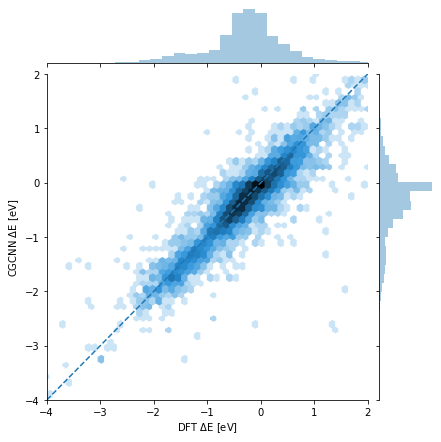

In [23]:
%matplotlib inline
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# import seaborn as sns
from collections import defaultdict
from matplotlib import pyplot as plt
from IPython.display import clear_output

targets_pred = predictions[int(np.argmin(MAE))].flatten() #torch.cat(pred).view(-1)
targets_val = labels[int(np.argmin(MAE))].flatten() #torch.cat(true).view(-1)

mae = mean_absolute_error(targets_val, targets_pred)
rmse = np.sqrt(mean_squared_error(targets_val, targets_pred))
r2 = r2_score(targets_val, targets_pred)

# Report
print('MAE = %.2f eV' % mae)
print('RMSE = %.2f eV' % rmse)
print('R^2 = %.2f' % r2)

# Plot
lims = [-4, 2]
grid = sns.jointplot(targets_val.reshape(-1), targets_pred,
                     kind='hex',
                     bins='log',
                     extent=lims+lims)
_ = grid.ax_joint.set_xlim(lims)
_ = grid.ax_joint.set_ylim(lims)
_ = grid.ax_joint.plot(lims, lims, '--')
_ = grid.ax_joint.set_xlabel('DFT $\Delta$E [eV]')
_ = grid.ax_joint.set_ylabel('CGCNN $\Delta$E [eV]')

In [24]:
# Calibration

import numpy as np
from scipy import stats
from tqdm import tqdm_notebook

residuals = (targets_pred - targets_val)#.numpy()
standard_errors = np.std(predictions, axis=0) 
print('res', np.mean(residuals))
print('stderr', np.mean(standard_errors))

def calculate_density(percentile):
    num_within_quantile = 0
    for se, resid in zip(standard_errors, residuals):
        norm = stats.norm(loc=0, scale=se)
        lower_bound = norm.ppf(0.5-percentile/2)
        upper_bound = norm.ppf(0.5+percentile/2)
        if lower_bound <= resid <= upper_bound:
            num_within_quantile += 1
    density = num_within_quantile / len(residuals)
    return density

predicted_pi = np.linspace(0, 1, 20)
observed_pi = [calculate_density(quantile)
               for quantile in tqdm_notebook(predicted_pi, desc='Calibration')]

res -0.05843751984948993
stderr 0.0047368472


Calibration factor = -0.46
Sharpness = 0.01 eV


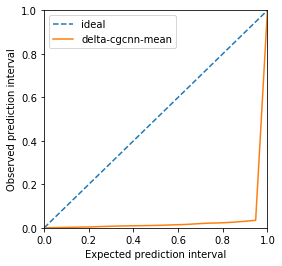

In [25]:
# Plotting Calibration

%matplotlib inline
import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt
import seaborn as sns


# Plot the calibration curve
fig = plt.figure(figsize=(4, 4))
ax_ideal = sns.lineplot([0, 1], [0, 1], label='ideal')
_ = ax_ideal.lines[0].set_linestyle('--')
ax_gp = sns.lineplot(predicted_pi, observed_pi, label='delta-cgcnn-mean')
_ = ax_gp.set_xlabel('Expected prediction interval')
_ = ax_gp.set_ylabel('Observed prediction interval')
_ = ax_gp.set_xlim([0, 1])
_ = ax_gp.set_ylim([0, 1])

# Report the calibration factor
actual_calibration_area = integrate.trapz(y=observed_pi, x=predicted_pi)
ideal_calibration_area = integrate.trapz(y=predicted_pi, x=predicted_pi)
calibration_factor = actual_calibration_area - ideal_calibration_area
print('Calibration factor = %.2f' % calibration_factor)

# Report sharpness
sharpness = np.sqrt(np.mean(standard_errors**2))
print('Sharpness = %.2f eV' % sharpness)